In [52]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_swiss_roll

In [53]:
def sample_batch(batch_size, device = 'cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2,0]] / 10
    data = data * np.array([1,-1])
    return data

data = sample_batch(10000)

(-2.0, 2.0)

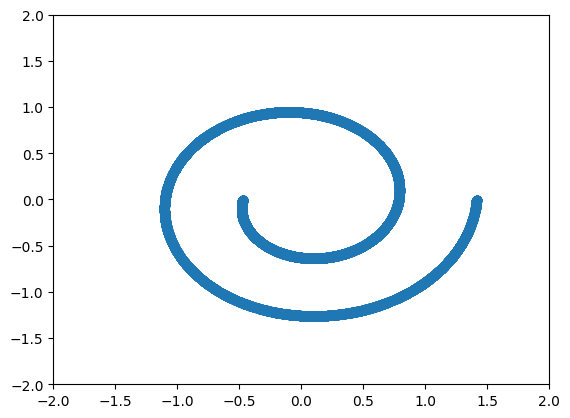

In [54]:
plt.scatter(data[:,0], data[:,1])
plt.xlim([-2,2])
plt.ylim([-2,2])

In [55]:
def forward_process(data, T, betas):

    for t in range(T):
        
        beta_t = betas[t]
        mu = data * torch.sqrt(1 - beta_t)
        std = torch.sqrt(beta_t)
        #Sample from q(x_t | x_{t-1})
        data = mu + torch.randn_like(data) * std   # data ~ N(mu,std)

    return data

In [56]:
T = 40
betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5 #np.linspace(start, stop, n)
xT = forward_process(torch.from_numpy(data), 40, betas)

In [57]:
print(xT.mean(0))
print(xT.std(0))

tensor([-0.0013, -0.0027], dtype=torch.float64)
tensor([0.9918, 0.9881], dtype=torch.float64)


(-4.0, 4.0)

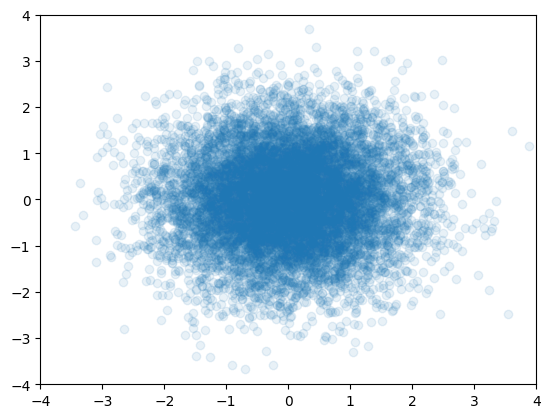

In [58]:
plt.scatter(xT[:,0], xT[:,1], alpha = 0.1)
plt.xlim([-4,4])
plt.ylim([-4,4])

In [59]:
class MLP(nn.Module):

    def __init__(self, N=40, data_dim = 2, hidden_dim = 64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),
                                          )
        self.network_tail = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim*2),
        ) for t in range(N)])

    def forward(self, x, t):
        '''
        data_dim = 2 -> x_t = [x1,x2]
        => mu = [mu1, mu2], std = [std1, std2] => output: data_dim*2
        '''

        h = self.network_head(x) #(batch_size, hidden_dim)
        tmp = self.network_tail[t](h) #(batch_size, data_dim*2)
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std


In [60]:
class DiffusionModel():

    def __init__(self, T, model : nn.Module, dim=2):
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T,)) * (3e-1-1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0) #cumulative product
        self.dim = dim
        self.T = T
        self.model = model
    
    def forward_process(self, x0, t):
        '''
        param t: Number of diffusion steps
        '''
        assert t > 0 , 't should be greater than 0'

        t = t - 1 #Because we start indexing at 0
        x0 = torch.tensor(x0)
        mu = torch.sqrt(self.alpha_bar[t]) * x0
        std = torch.sqrt(1-self.alpha_bar[t])
        epsilon = torch.randn_like(x0)
        xt = mu + std * epsilon

        m1 = torch.sqrt(1 - self.alpha_bar[t-1]) * self.betas[t] / torch.sqrt(1 - self.alpha_bar[t])
        m2 = torch.sqrt(self.alphas[t]) * (1 - self.alpha_bar[t-1])/ torch.sqrt(1 - self.alpha_bar[t])
        mu_q = m1 * x0 + m2 * xt 
        std_q = torch.sqrt((1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t])) * self.betas[t]
        
        return mu_q, std_q, xt
    
    def reverse_process(self, xt, t):
        '''
        param t: Number of diffusion steps
        '''
        assert t > 0 , 't should be greater than 0'

        t = t - 1 #Because we start indexing at 0
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)

        return mu, std, mu + epsilon * std # data ~ N(mu, std)

    def sample(self, batch_size):
        noise = torch.randn((batch_size, self.dim ))
        x = noise

        samples = [x]
        for t in range(self.T, 0 , -1):
            x = self.reverse_process(x,t)[-1]
            samples.append(x) #(timestep, batch_size, data_dim)
        return samples[::-1] # reverse samples

    def get_loss(self, x0):
        '''
        param x0: batch [batch_size, self.dim]
        '''
        t = torch.randint(2,41,(1,)) #Monte Carlo Sampling
        mu_q , std_q, xt = self.forward_process(x0, t)
        mu_p, std_p, xt_minus1 = self.reverse_process(xt.float(), t)


        
        KL = (torch.log(std_q) - torch.log(std_q) + (
            std_q**2 + (mu_q - mu_p)**2)/ ( 2 * std_q**2 ))
        K = (KL).mean() #Should be maximized
        loss = - K #Should be minimized        
        return loss
    

In [61]:
MLPModel = torch.load('model_paper1')
model = DiffusionModel(40, MLPModel)
data = sample_batch(3000)
x0 = torch.from_numpy(data)
x20 = model.forward_process(x0, 20)[-1]
xT = model.forward_process(x0, 40)[-1]
samples = model.sample(3000)

C:\Users\bolkv\AppData\Local\Temp\ipykernel_6540\717067309.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  MLPModel = torch.load('model_paper1')
C:\Users\bolkv\AppData\L

In [62]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0242, -0.0060], dtype=torch.float64)
tensor([0.9847, 0.9916], dtype=torch.float64)


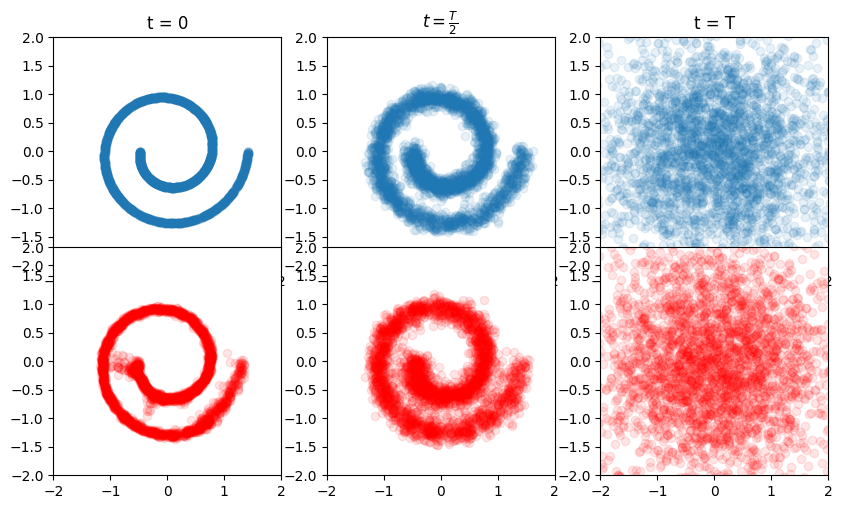

In [63]:
fig = plt.figure(figsize = (10, 10))

data = [x0, x20  ,xT]
for i in range(3):
    plt.subplot(1,3,1+i) # row: 1, col: 3, n = 1+i
    plt.scatter(data[i][:,0], data[i][:,1], alpha = 0.1)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.gca().set_aspect('equal')

    if i == 0: plt.title('t = 0')
    elif i == 1: plt.title(r'$t = \frac{T}{2}$')
    elif i == 2: plt.title('t = T')

time_steps = [1, 20, 40]
for i in range(3):
    plt.subplot(2,3,4+i) # row: 1, col: 3, n = 1+i
    plt.scatter(samples[time_steps[i]][:,0].data.numpy(), samples[time_steps[i]][:,1].data.numpy(), alpha = 0.1, c = 'r')
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.gca().set_aspect('equal')
 


In [ ]:
x0 = sample_batch(128)
loss = model.get_loss(x0)
print(loss)

def train(diffusion_model, optimizer, batch_size, nb_epochs):
    
    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        x0 = sample_batch(batch_size)
        loss = diffusion_model.get_loss(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss.append(loss.item())
    return training_loss

mlp_model = MLP(hidden_dim=128)
model = DiffusionModel(40, mlp_model)
optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 1e-4 )

train(model, optimizer, 64000, 30000)